# REFINED_HDN_3

Best result so far is provided by applying a 3D N2V on the video stacks.
Some noise is still present, although its variance in the time dimension has been greatly reduced. 

In this experiment we apply Hierarchical DivNoising to the data to remove more noise.
HDN requires to build a Noise Model. This is usually done by training a Gaussian Mixture Model or a simpler histogram model on Low and High SNR pairs.
Since we don't have such pairs at our disposal we can approximate the noise model by comparing the output of REFINED_N2V_3 and the raw dataset.

## Bootstrapping a Noise Model using REFINED_N2V_3 outputs

To _bootstrap_ a Noise Model we use the output of REFINED_N2V_3 as an High SNR signal and the raw input as the noisy input.

To train a GMM Noise Model, run the following code in your terminal / HPC:

```

python -u train_noise_model.py 
       -e .env_hpc 
       --level DEBUG 
       --signal_folder=/your_path_to/calcium_imaging/refined/train  
       --denoised_folder=output/REFINED_N2V_3/train 
       --experiment_name=REFINED_HDN_3 
       --random_perc=0.1
```

## Loading the Noise Model

Loading the noise model trained in the previous step

In [1]:
experiment_name = "REFINED_HDN_3"

# Datasets
TRAIN_DATASET_PATH = "/localscratch/calcium_imaging_dataset/calcium_imaging/refined/train"
VAL_DATASET_PATH = "/localscratch/calcium_imaging_dataset/calcium_imaging/refined/val"
TEST_DATASET_PATH = "/localscratch/calcium_imaging_dataset/calcium_imaging/refined/test"

signal_folder = TRAIN_DATASET_PATH
denoised_folder = "output/REFINED_N2V_3/train"
gmm_to_load = f"models/{experiment_name}/noise_model/GMM.npz"

device = "cuda"

# Training
num_epochs = 500
lr = 3e-4
steps_per_epoch = 400
test_batch_size = 100
hdn_model_path = f"models/{experiment_name}/hdn/"


PATCH_SIZE = 64
TILE_SIZE = 32
BATCH_SIZE = 64

data_shape = [1009, 1024, 1024]


In [ ]:
from hdn.lib.gaussianMixtureNoiseModel import GaussianMixtureNoiseModel
from pathlib import Path
import numpy as np


noise_model = GaussianMixtureNoiseModel(    
                                    path=Path(gmm_to_load).parent, 
                                    device = device, 
                                    params = np.load(gmm_to_load, allow_pickle=True)
                                )


# Visualizing Likelihood


Compute min and max values for setting the visualization range

In [ ]:
import math
import tifffile

# Get vmin, vmax
RECOMPUTE = False
GMM_TRAINED_ON_NORMALIZED_DATA = True if "run2" in experiment_name else False

if RECOMPUTE:
    signal = []
    for p in list(Path(signal_folder).rglob("*.tif")):
        i = tifffile.imread(p)
        signal.append(i)
    signal = np.array(signal)

    if GMM_TRAINED_ON_NORMALIZED_DATA:
        signal = (signal - signal.mean()) / signal.std()

    s_vmin, s_vmax = signal.min(), signal.max()
    print(f"Signal min: {s_vmin} max: {s_vmax}")

    observations = []
    for p in list(Path(denoised_folder).rglob("*.tif")):
        i = tifffile.imread(p)
        observations.append(i)
    observations = np.array(observations)

    if GMM_TRAINED_ON_NORMALIZED_DATA:
        observations = (observations - observations.mean()) / observations.std()
        
    o_vmin, o_vmax = observations.min(), observations.max()
    print(f"Observation min: {o_vmin} max: {o_vmax}")
    
    del signal
    del observations

else:
    # Precomputed value for REFINED dataset
    if not GMM_TRAINED_ON_NORMALIZED_DATA:
        s_vmin, s_vmax = 721, 1032
        o_vmin, o_vmax = 783.7182006835938, 999.6793212890625
    else:
        s_vmin, s_vmax = -9.679607026102817, 19.534994121371106
        o_vmin, o_vmax = -4.591809272766113, 19.57579803466797
    print(f"Signal min: {s_vmin} max: {s_vmax}")
    print(f"Observation min: {o_vmin} max: {o_vmax}")

vmin = math.floor(min(s_vmin, o_vmin))
vmax = math.ceil(max(s_vmax, o_vmax))    

## Interactive visualization

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

def plot_gmm_likelihood(gaussianMixtureNoiseModel, min_signal, max_signal, n_bin, device):
    """
    Interactive function to analyze the GMM likelihood for various signal values.
    Uses ipywidgets for dynamic interaction.
    
    Args:
        gaussianMixtureNoiseModel: A GMM with a `likelihood(observations, signal)` method.
        min_signal (float): Minimum signal value.
        max_signal (float): Maximum signal value.
        n_bin (int): Number of bins for discretizing the signal range.
        device (torch.device): Device for tensor computations (CPU/GPU).
    """
    def update(signal_value):
        # Discretize the observation range
        bin_size = (max_signal - min_signal) / n_bin
        observation_values = np.arange(min_signal, max_signal, bin_size) + bin_size / 2
        observations_torch = torch.from_numpy(observation_values).float().to(device)
        
        # Convert the signal value to tensor
        signal_torch = torch.tensor(signal_value, dtype=torch.float32).to(device)
        
        # Compute likelihood from the GMM
        likelihood_torch = gaussianMixtureNoiseModel.likelihood(observations_torch, signal_torch)
        likelihood_numpy = likelihood_torch.cpu().detach().numpy()
        
        # Plot the likelihood
        plt.figure(figsize=(10, 5))
        plt.plot(observation_values, likelihood_numpy, label=f'GMM Likelihood (s = {signal_value:.2f})', color='red', linewidth=2)
        plt.ylim(0, 1)  # Fix y-axis scale
        plt.xlabel('Observation (x)')
        plt.ylabel('Probability Density')
        plt.title(f'Probability Distribution P(x|s) for Signal s = {signal_value:.2f}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Create interactive slider for signal value
    interact(update, signal_value=FloatSlider(value=(min_signal + max_signal) / 2, 
                                              min=min_signal, max=max_signal, step=(max_signal - min_signal) / 100))

plot_gmm_likelihood(noise_model, vmin, vmax, 1000, device)

## 2D visualization
By plotting the input signal values on the vertical axis and the likelihood on the horizontal axis we can notice that the noise is dependent on the signal value. In particular, pixel intensities tend to have more variance the higher the signal is.

In [ ]:
def plot_likelihood_as_image(model=noise_model, vmin=vmin, vmax=vmax):
    img = list()

    for h in range(vmin, vmax+1):
        observation_values = np.arange(vmin, vmax)
        observations_torch = torch.from_numpy(observation_values).float().to(device)
        
        # Convert the signal value to tensor
        signal_torch = torch.tensor([h], dtype=torch.float32).to(device)
        
        # Compute likelihood from the GMM
        likelihood_torch = model.likelihood(observations_torch, signal_torch)
        likelihood_numpy = likelihood_torch.cpu().detach().numpy()
        
        img.append(likelihood_numpy)
        
    img = np.array(img)
    plt.imshow(img, cmap="inferno")
    n_ticks = 5
    plt.xticks(ticks=np.linspace(0, img.shape[1]-1, n_ticks).tolist(), labels=np.linspace(vmin, vmax, n_ticks).tolist())
    plt.yticks(ticks=np.linspace(0, img.shape[0]-1, n_ticks).tolist(), labels=np.linspace(vmin, vmax, n_ticks).tolist())

plot_likelihood_as_image()


# Training a 2D HDN Model

Once we have obtained a noise model for our data, we can now train the HDN model.
HDN is based on LadderVAE architecture, which requires some statistics of the input data

Since training HDN is resource-intensive, we can train and predict using tiling and patching.
We will use predtiler to manage 2D tiling and call the following script to train the model:

```bash
python hdn_2d_train.py -e .env_hpc --level DEBUG --experiment_name=REFINED_HDN_3 --batch_size=128
```

# Predict with HDN (2D)

In [2]:
from torch.utils.data import Dataset
from typing import Tuple
from predtiler.tile_stitcher import stitch_predictions
from predtiler.dataset import get_tiling_dataset, get_tile_manager
from torch.utils.data import DataLoader

from datasets import make_predtiler_dataset

PatchedCalciumImagingDataset = make_predtiler_dataset(data_shape=data_shape,
                                                      tile_size=TILE_SIZE,
                                                      patch_size=PATCH_SIZE)

train_dataset = PatchedCalciumImagingDataset(TRAIN_DATASET_PATH, patch_size=PATCH_SIZE)
#val_dataset  = PatchedCalciumImagingDataset(VAL_DATASET_PATH, patch_size=PATCH_SIZE)
#test_dataset  = PatchedCalciumImagingDataset(TEST_DATASET_PATH, patch_size=PATCH_SIZE)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
#val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
#test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)




## Define HDN Model

In [ ]:
import torch
import sys
from tqdm import tqdm

sys.path.append('hdn')

hdn_model = torch.load("/group/jug/edoardo/projects/CalciumImagingDenoising/models/REFINED_HDN_3/hdnmodel/REFINED_HDN_3_last_vae.net")
hdn_model.mode_pred=True
hdn_model.eval()


predictions_patches = []

with torch.no_grad():
    for x, y in tqdm(train_loader):
        x = x[:, None, ...].float().to("cuda")
        o = hdn_model(x)['out_sample'].cpu()
        predictions_patches.append(o)

print("Stitching predictions...")
predictions = np.concatenate(predictions_patches, axis=0)
stitched_pred = stitch_predictions(predictions, train_dataset.tile_manager)


/tmp/ipykernel_8675/3883852788.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hdn_model = torch.load("/group/jug/edoardo/projects/CalciumImagingDenoising/models/REFINED

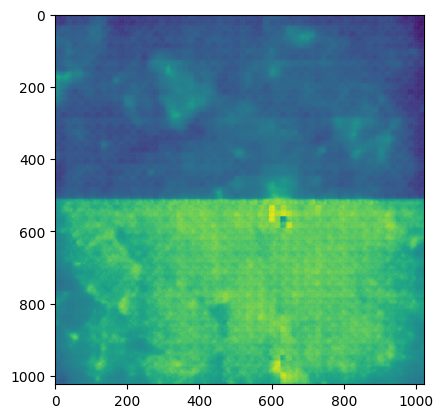

In [18]:
import matplotlib.pyplot as plt

plt.imshow(stitched_pred[100])

In [10]:
import numpy as np
np.save("temp_hdn_3_patches_pred.npz", predictions)

In [ ]:
predictions = np.stack(predictions) # prediction should have shape: (number_of_patches, C, patch_size, patch_size)
